O objetivo dessa análise exploratória foi entender melhor os dados visando a etapa de modelagem para Machine Learning e ao mesmo tempo gerar insights que possam ser úteis ao setor de negócio.

Principais descobertas:
- Os clientes que saem da empresa são em média 12% mais lucrativos do que os que permanecem, o que evidencia a importância de reduzir o churn.
- Clientes que fazem o churn realizam 54% mais chamadas de serviço ao consumidor e enviam cerca de 40% menos mensagens por voz do que clientes que permanecem.
- Clientes que fazem o churn são mais ativos no período da manhã do que clientes que permanecem.
- A adesão apenas do plano internacional parece estar relacionada com uma maior evasão, tendo em vista que mais de 20% dos clientes rotativos possuem somente esse plano enquanto a porcentagem dos que permanecem e tem esse mesmo plano é de apenas 10%.
- A taxa de churn variou de 5% a 26% com uma média de 14% (± 5%) nos estados americanos.
- California (CA) e Virginia Ocidental(WV) e Carolina do Sul (SC) foram estados problemáticos. CA foi o estado com a segunda maior taxa de churn e o menor número de clientes, talvez reflexo da forte concorrência por se tratar de um dos estados mais populosos do EUA. WV e SC apresentaram um alto número de clientes e uma baixa renda média, o que abre a possibilidade de tentar um pequeno reajuste afim de aumentar a rentabilidade nesses locais.
- Por outro lado Wisconsin (WI) e Virginia (VA) foram estados com alto número de clientes e baixa taxa de churn, mostrando que nesses estados a uma fidelidade interessante.  

# Pacotes Utilizados

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import levene
import statsmodels.api as sm
from sklearn.metrics import mutual_info_score

from category_encoders import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.model_selection import FeatureImportances
from sklearn.ensemble import RandomForestClassifier


pd.options.display.max_columns = 50
pd.set_option("display.precision", 3)
custom_params = {"axes.spines.left": False, "axes.spines.bottom": False, "axes.spines.top":False, "axes.spines.right":False}
sns.set_theme(rc = custom_params, style="white", palette="muted", font_scale=1) #Muted #pastel

# Primeira Olhada nos Dados

In [2]:
train_raw = pd.read_csv("../data/train.csv")
test_raw = pd.read_csv("../data/train.csv")

In [3]:
#cópia dos dataframes originais
train = train_raw.copy()
test = test_raw.copy()

In [4]:
#shape dos dados
print(f"Treino: {train.shape[0]} linhas e {train.shape[1]} colunas")
print(f"Teste: {test.shape[0]} linhas e {test.shape[1]} colunas")

Treino: 3333 linhas e 21 colunas
Teste: 3333 linhas e 21 colunas


In [18]:
print(f" Valores missing em treino: {train.isnull().sum().sum()}")
print(f" Valores missing em teste: {train.isnull().sum().sum()}")

 Valores missing em treino: 0
 Valores missing em teste: 0


In [5]:
train.head()

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     3333 non-null   int64  
 1   state                          3333 non-null   object 
 2   account_length                 3333 non-null   int64  
 3   area_code                      3333 non-null   object 
 4   international_plan             3333 non-null   object 
 5   voice_mail_plan                3333 non-null   object 
 6   number_vmail_messages          3333 non-null   int64  
 7   total_day_minutes              3333 non-null   float64
 8   total_day_calls                3333 non-null   int64  
 9   total_day_charge               3333 non-null   float64
 10  total_eve_minutes              3333 non-null   float64
 11  total_eve_calls                3333 non-null   int64  
 12  total_eve_charge               3333 non-null   f

In [29]:
# Cardinalidade das features categóricas
for var in train.select_dtypes(include="object").columns:
    cardinality = len(set(train[var].values))
    print(f"{var} --- {cardinality} valores distintos")

state --- 51 valores distintos
area_code --- 3 valores distintos
international_plan --- 2 valores distintos
voice_mail_plan --- 2 valores distintos
churn --- 2 valores distintos


In [31]:
# Verificando se mesmas categorias estão presente em treino e teste
for var in train.select_dtypes(include="object").columns:
    if set(train[var].values) == set(train[var].values):
        print(f"{var} ---- Mesmas categorias em treino e teste")
    else:
        print(f"{var} ---- Categorias diferentes entre treino e teste" )
    

state ---- Mesmas categorias em treino e teste
area_code ---- Mesmas categorias em treino e teste
international_plan ---- Mesmas categorias em treino e teste
voice_mail_plan ---- Mesmas categorias em treino e teste
churn ---- Mesmas categorias em treino e teste


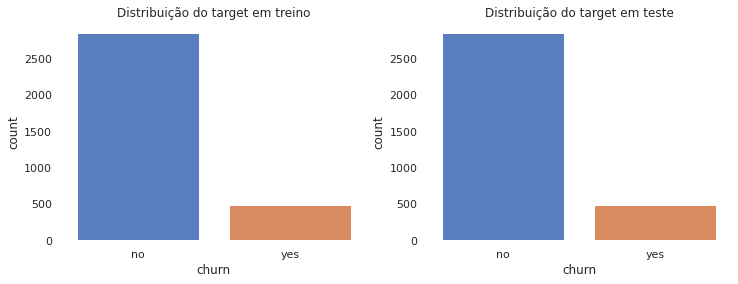

In [39]:
#target
fig, ax = plt.subplots(1,2, figsize = (12,4))
sns.countplot(data=train, x = "churn", ax = ax.flat[0])
sns.countplot(data=test, x = "churn", ax = ax.flat[1])

ax.flat[0].set(title = "Distribuição do target em treino")
ax.flat[1].set(title = "Distribuição do target em teste");

In [46]:
train.churn.value_counts(normalize=False)

no     2850
yes     483
Name: churn, dtype: int64

Até aqui:

- Não há valores faltantes nos datasets

- Das features categóricas que necessitam de enconde, 3 são binárias (voice_mail_plan, international_plan e churn), 1 possui baixa cardinalidade (area_code) e 1 possui alta cardinalidade (state)

- A variável target (churn) está desbalanceada. Para cada cliente que faz o churn outros 6 permanecem na empresa. Embora essa proporção seja esperada e reflita a realidade em problemas dessa natureza, o modelo criado pode ter problemas em aprender sobre a classe de interesse (yes) devido ao baixo número de ocorrências.


Para facilitar a análise exploratória, uni os conjuntos de treino e teste. Fiz isso pq já havia demosntrado na iteração anterior que os dois conjuntos são similiraes por meio da  *Adversarial Validation*. Na etapa de modelagem para *Machine Learning* voltarei a tratar os dados em separado.

In [6]:
df = pd.concat([train,test], axis = 0).reset_index(drop=True)

# Feature Enginering

As seguintes alterações serão criadas no dataset:
- recharge_total: cobrança total de chamadas em todos os períodos do dia (total_day_charge + total_eve_charge + total_night_charge + total_intl_charge)
- minutes_total: total de minutos em todos os períodos do dia (total_day_minutes + total_eve_minutes + total_night_minutes + total_intl_minutes)
- calls_total: total de chamadas em todos os períodos do dia (total_day_calls + total_eve_calls + total_night_calls + total_intl_calls)
- rechargesPerMinute: cobrança por minuto gerada por cada cliente (charge_total / minutes_total)
- plan: combinação dos planos adquiridos (Nenhum, Apenas Correio de Voz, Apenas Internacional ou Ambos)


As seguintes features serão excluidas:
- Unnamed: 0 

In [8]:
df.drop("Unnamed: 0", axis = 1, inplace=True)
df["recharge_total"] = df[[i for i in train.columns if "charge" in i]].sum(axis = 1)
df["minutes_total"] = df[[i for i in train.columns if "minutes" in i]].sum(axis = 1)
df["calls_total"] = df[[i for i in train.columns if "calls" in i]].sum(axis = 1)
df["rechargesPerMinute"] = df["recharge_total"] / df["minutes_total"]

def label(row):
    if (row["international_plan"] == "no") and (row["voice_mail_plan"] == "no"):
        return "Nenhum"
    
    if (row["international_plan"] == "yes") and (row["voice_mail_plan"] == "no"):
        return "Apenas Internacional"
    
    if (row["international_plan"] == "no") and (row["voice_mail_plan"] == "yes"):
        return "Apenas Correio de Voz"
    else:
        return "Ambos"

df["plan"] = df.apply (lambda row: label(row), axis=1)

In [11]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,recharge_total,minutes_total,calls_total,rechargesPerMinute,plan
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no,75.56,717.2,304,0.105,Apenas Correio de Voz
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no,59.24,625.2,333,0.095,Apenas Correio de Voz
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no,62.29,539.4,333,0.115,Nenhum
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no,66.80,564.8,257,0.118,Apenas Internacional
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no,52.09,512.0,362,0.102,Apenas Internacional


In [12]:
df.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,recharge_total,minutes_total,calls_total,rechargesPerMinute
count,6666.000,6666.000,6666.000,6666.000,6666.000,6666.00,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000
mean,101.065,8.099,179.775,100.436,30.562,200.98,100.114,17.084,200.872,100.108,9.039,10.237,4.479,2.765,1.563,59.450,591.865,306.700,0.100
std,39.819,13.687,54.463,20.068,9.259,50.71,19.921,4.310,50.570,19.567,2.276,2.792,2.461,0.754,1.315,10.501,89.948,34.447,0.008
min,1.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,23.200,33.000,1.040,0.000,0.000,0.000,0.000,22.930,284.300,194.000,0.067
25%,74.000,0.000,143.700,87.000,24.430,166.60,87.000,14.160,167.000,87.000,7.520,8.500,3.000,2.300,1.000,52.380,531.500,284.000,0.095
50%,101.000,0.000,179.400,101.000,30.500,201.40,100.000,17.120,201.200,100.000,9.050,10.300,4.000,2.780,1.000,59.470,593.600,307.000,0.100
75%,127.000,20.000,216.400,114.000,36.790,235.30,114.000,20.000,235.300,113.000,10.590,12.100,6.000,3.270,2.000,66.480,652.400,330.000,0.106
max,243.000,51.000,350.800,165.000,59.640,363.70,170.000,30.910,395.000,175.000,17.770,20.000,20.000,5.400,9.000,96.150,885.000,418.000,0.130


# Análise Univariada

## Avaliando Normalidade

In [24]:
#isolando variaveis continuas
cont_vars = list(df.select_dtypes(include=np.number).columns)
cont_vars

['account_length',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'recharge_total',
 'minutes_total',
 'calls_total',
 'rechargesPerMinute']

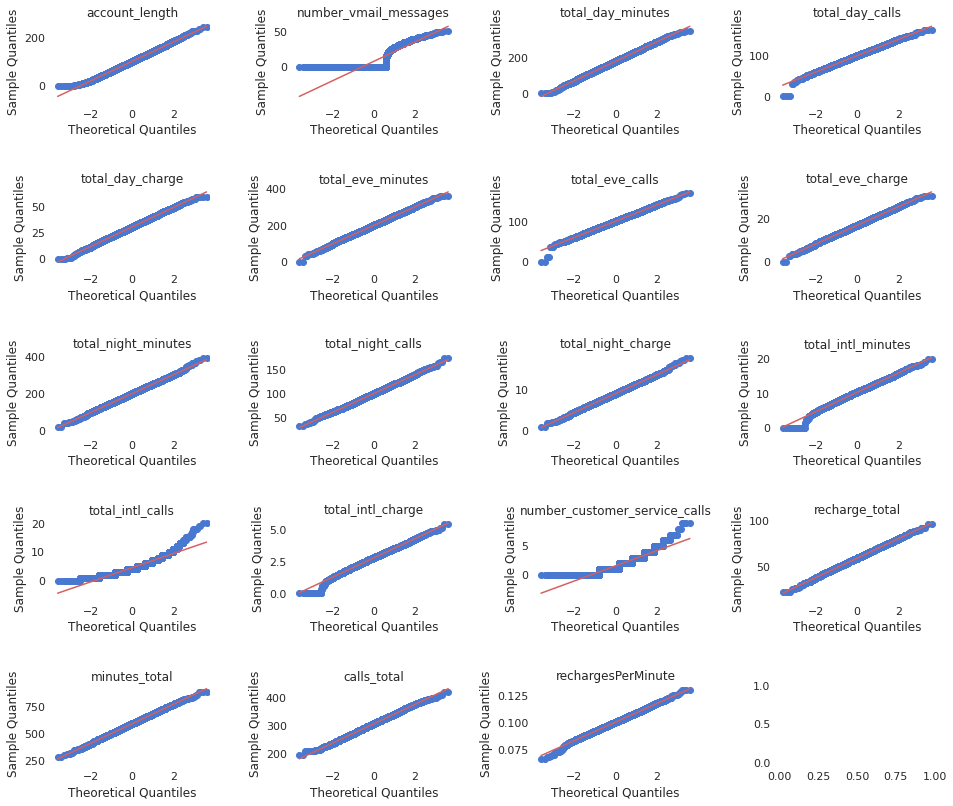

In [22]:
fig, ax = plt.subplots(5,4, figsize = (14,12))
for index, var in enumerate(cont_vars):
    values = df[var].values
    sm.qqplot(values, line = "s", ax = ax.flat[index] )
    ax.flat[index].set(title = f"{var}");
fig.tight_layout(pad=3)

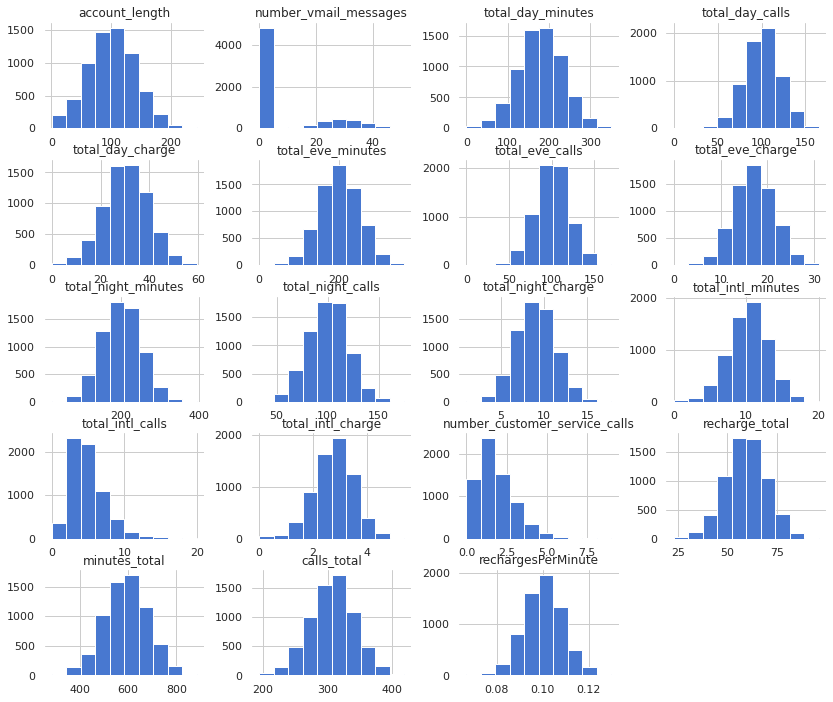

In [23]:
df[cont_vars].hist(figsize=(14,12),);

A partir dos qqplots e do histograma nota-se que no geral, a distribuição das features se assemelha a normal. Vamos assumir que essa normalidade é suficiente para o uso de testes de hipotéses paramétricos. Como cada observação é independente, usaremos o **teste t** para comparar a média de duas amostras da população seguindo as premissas :

- H0: média das amostras são iguais
- H1: médias das amostras são diferentes
- cut-off para rejeitar a H0: 0.05

Ainda, o teste t tem a suposição de que as amostras tenham a mesma variância. Quando isso não for verdade usaremos uma variação do teste t (Welch’s) que não possui essa suposição. Para checar se as variâncias são iguais será utilziado o **teste de levene** com as mesmas hipóteses e nível de significância definidos acima.

In [27]:
def t_test(varname):
    """ Função que aplica o teste de levene seguido do teste t (quando variâncias forem iguais) 
    ou teste t Welch’s (quando variâncias forem diferentes) 
    """
    
    sample1 = df[df["churn"] == "Sim"][varname]
    sample2 = df[df["churn"] == "Não"][varname]
    
    _ ,p_levene = levene(sample1, sample2, center = "mean")
    
    
    if p_levene > 0.05: 
        print("Variancia das amostras são iguais. Aplicando o T-test: ")
        stat, p = ttest_ind(a = sample1, b = sample2)
        print(f"stat = {stat:.3f} p_value = {p:.3f}")
        if p > 0.05:
            print('Não há evidências suficientes para rejeitar H0. Média das amostras são iguais')
        else:
            print('Rejeitamos a H0. A média da amostras são diferentes')
            
    else:
        print('Amostras com diferentes variância, aplicando o Welch’s t-test: ')
        stat, p = ttest_ind(a = sample1, b = sample2, equal_var = False)
        print(f"stat = {stat:.3f} p_value = {p:.3f}")
        if p > 0.05:
            print('Não há evidências suficientes para rejeitar H0. Média das amostras são iguais')
        else:
            print('Rejeitamos a H0. A média da amostras são diferentes')

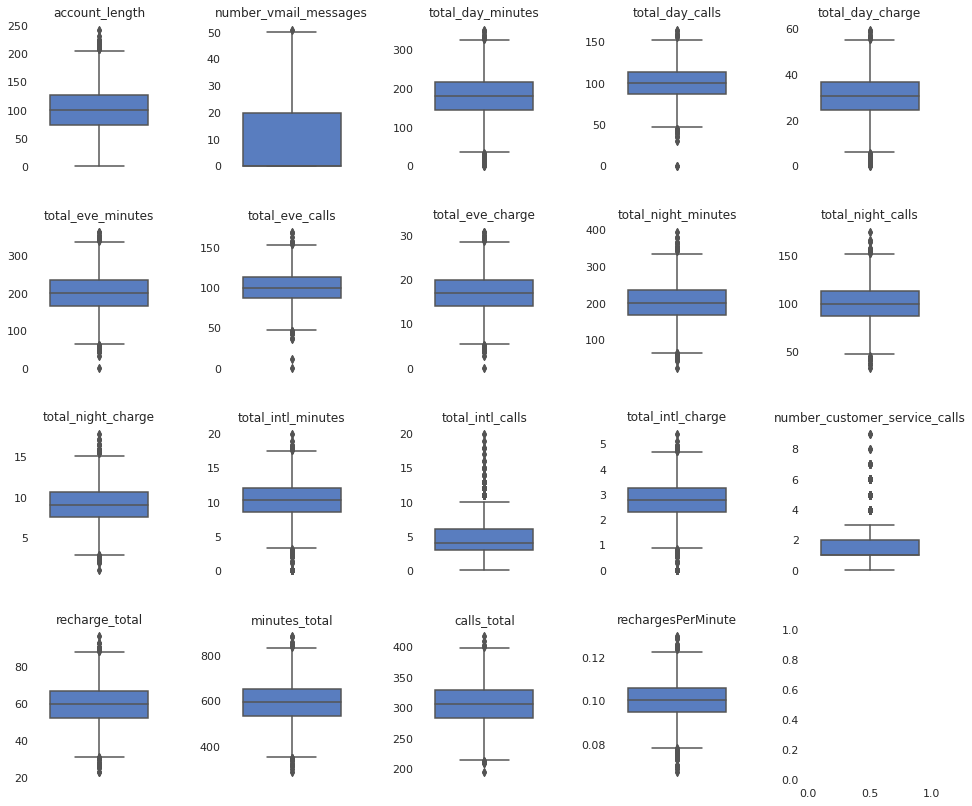

In [31]:
fig,ax = plt.subplots(4,5, figsize = (14,12))

for index, var in enumerate(cont_vars):
    sns.boxplot(data = df, y = var, ax = ax.flat[index])
    ax.flat[index].set(title = var, ylabel = "")
fig.tight_layout(pad=3)

In [29]:
df[cont_vars].describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,recharge_total,minutes_total,calls_total,rechargesPerMinute
count,6666.000,6666.000,6666.000,6666.000,6666.000,6666.00,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000,6666.000
mean,101.065,8.099,179.775,100.436,30.562,200.98,100.114,17.084,200.872,100.108,9.039,10.237,4.479,2.765,1.563,59.450,591.865,306.700,0.100
std,39.819,13.687,54.463,20.068,9.259,50.71,19.921,4.310,50.570,19.567,2.276,2.792,2.461,0.754,1.315,10.501,89.948,34.447,0.008
min,1.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,23.200,33.000,1.040,0.000,0.000,0.000,0.000,22.930,284.300,194.000,0.067
25%,74.000,0.000,143.700,87.000,24.430,166.60,87.000,14.160,167.000,87.000,7.520,8.500,3.000,2.300,1.000,52.380,531.500,284.000,0.095
50%,101.000,0.000,179.400,101.000,30.500,201.40,100.000,17.120,201.200,100.000,9.050,10.300,4.000,2.780,1.000,59.470,593.600,307.000,0.100
75%,127.000,20.000,216.400,114.000,36.790,235.30,114.000,20.000,235.300,113.000,10.590,12.100,6.000,3.270,2.000,66.480,652.400,330.000,0.106
max,243.000,51.000,350.800,165.000,59.640,363.70,170.000,30.910,395.000,175.000,17.770,20.000,20.000,5.400,9.000,96.150,885.000,418.000,0.130


É possível notar presença de alguns *outliers*. Como esses valores não aparentam ser irreais vamos mante-los por enquanto.

# Multivariada

Aqui focaremos em visualizar a relação das variáveis com o churn, validando as diferenças observadas visualmente por meio do teste de hipótese definido na seção anterior.

### Panorama Geral

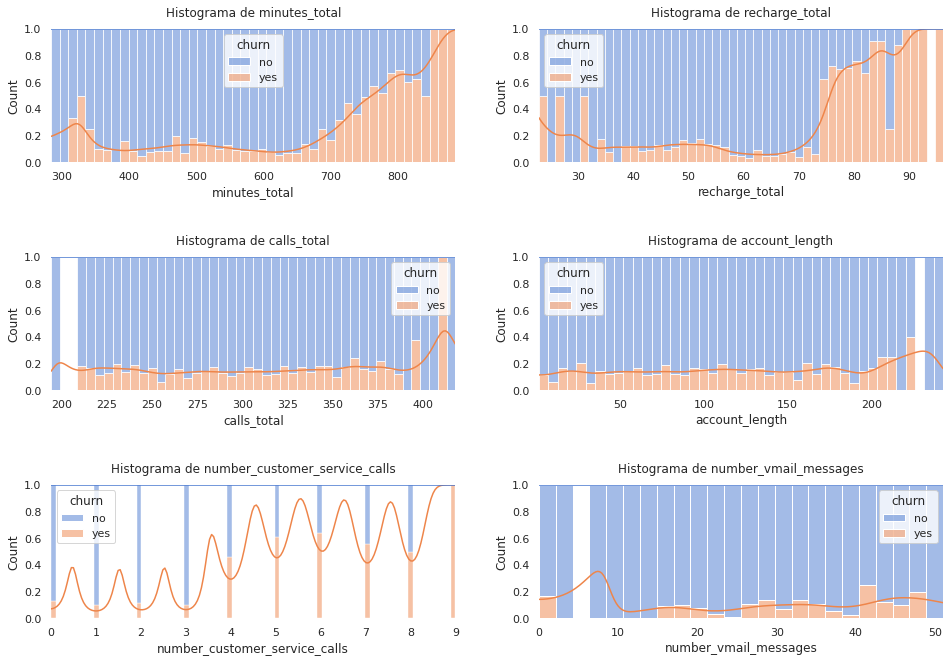

In [9]:
vars_histplot = ["minutes_total", "recharge_total", "calls_total", "account_length", "number_customer_service_calls", "number_vmail_messages"]
fig, ax = plt.subplots(3, 2, figsize = (14,10))
for index, var in enumerate(vars_histplot):
    sns.histplot(x = df[var], hue = df["churn"], kde = True, multiple = "fill", ax = ax.flat[index]);
    ax.flat[index].set_title(label=f'Histograma de {var}', pad=12)
fig.tight_layout(pad=3)

- Podemos notar um aumento do churn quando há um alto número de chamdas ou maior valores de cobranças. Isso mostra que os clientes mais lucrativos (maiores valores de recharge_total) e que passam mais tempo em chamada (maiores valores de minute_total) são, em sua maior parte, justamente aqueles que abandonam a empresa. Esse insight reforça a importância de definir medidas voltadas a aumentar a retenção de clientes, tendo em vista que esses são muitas vezes mais valiosos que os que permanecem.
- A proporção de churn aumenta conforme mais chamadas de atendimento ao cliente são realizada. Isso faz sentido uma vez que essas chamdas podem ser um indicativo de insatisfação.
- Número de ligações, mensagens enviadas e o número de meses que o cliente está com o provedor de telecomunicações atual não parecem estar relacionado com a evasão de clientes.

Vamos explorar um pouco mais essas descobertas

### Recharge Total vs Churn

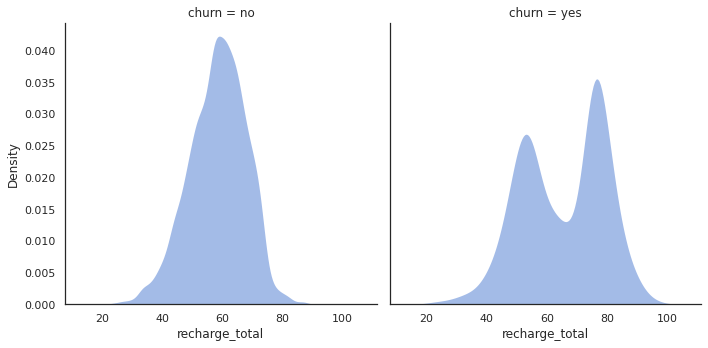

In [27]:
sns.displot(x = df["recharge_total"], col = df["churn"], kind = "kde", fill = True, common_norm=False, alpha=.5, linewidth=0);

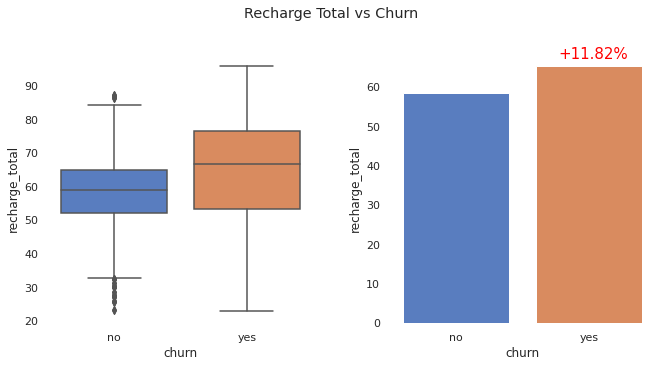

In [29]:
mean_not_churn = df[df["churn"] == "no"]["recharge_total"].mean()
mean_churn = df[df["churn"] == "yes"]["recharge_total"].mean()

dif = ((mean_churn - mean_not_churn) / mean_not_churn)*100

fig, ax = plt.subplots(1,2, figsize = (10,6))
sns.boxplot(data = df, x = "churn", y = "recharge_total", ax =ax[0])
sns.barplot(data = df, x = "churn", y = "recharge_total", ci = None, ax = ax[1])

ax[1].annotate(text = f"+{dif:.2f}%", xy = (1, mean_churn), xycoords = "data", size = 15, xytext=(-30, +7), textcoords='offset points', color = "red") 
plt.suptitle("Recharge Total vs Churn", x = 0.5, y = 0.9)
fig.tight_layout(pad=3);

In [28]:
t_test("recharge_total")

Amostras com diferentes variância, aplicando o Welch’s t-test 
stat = 13.032 p_value = 0.000
Rejeitamos a H0. A média da amostras são diferentes


- Clientes que fazem churn geram em média cerca de 12% a mais de receita recebida na forma de cobranças do que os que permanecem na empresa.
- O valor gerado por clientes rotativos tem uma distribuição bimodal com o segundo pico próximo a 80, consideravelmente superior ao primeiro pico (55) e ao pico observado na distribuição dos não rotativos (60). Indicando que existem clientes que são mais valiosos dentro daqueles que fizeram o churn.

### Ligações para Atendimento ao Cliente vs Churn

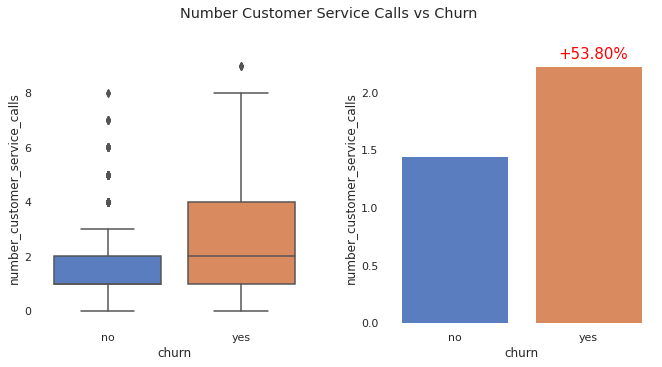

In [31]:
mean_not_churn = df[df["churn"] == "no"]["number_customer_service_calls"].mean()
mean_churn = df[df["churn"] == "yes"]["number_customer_service_calls"].mean()

dif = ((mean_churn - mean_not_churn) / mean_not_churn)*100

fig, ax = plt.subplots(1,2, figsize = (10,6))
sns.boxplot(data = df, x = "churn", y = "number_customer_service_calls", ax =ax[0])
sns.barplot(data = df, x = "churn", y = "number_customer_service_calls", ci = None, ax = ax[1])

ax[1].annotate(text = f"+{dif:.2f}%", xy = (1, mean_churn), xycoords = "data", size = 15, xytext=(-30, +7), textcoords='offset points', color = "red") 
plt.suptitle("Number Customer Service Calls vs Churn ", x = 0.5, y = 0.9)
fig.tight_layout(pad=3);

In [29]:
t_test("number_customer_service_calls")

Amostras com diferentes variância, aplicando o Welch’s t-test 
stat = 11.292 p_value = 0.000
Rejeitamos a H0. A média da amostras são diferentes


- Clientes que fazem o churn realizam em média 54,67% mais chamadas para atendimento ao cliente em relação aos clientes que permanecem. Pode ser um indicio importantede de churn.

### Chamadas Totais vs Churn 

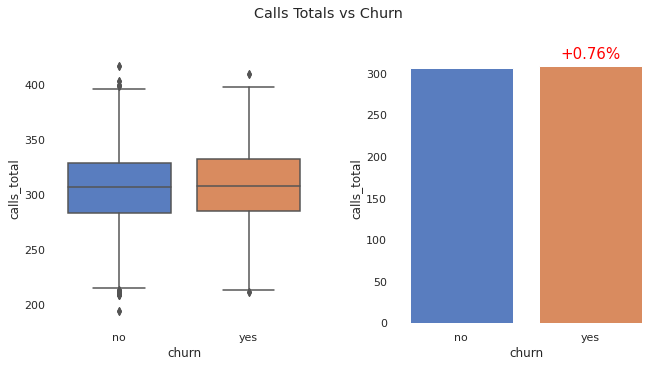

In [34]:
mean_not_churn = df[df["churn"] == "no"]["calls_total"].mean()
mean_churn = df[df["churn"] == "yes"]["calls_total"].mean()

dif = ((mean_churn - mean_not_churn) / mean_not_churn)*100

fig, ax = plt.subplots(1,2, figsize = (10,6))
sns.boxplot(data = df, x = "churn", y = "calls_total", ax =ax[0])
sns.barplot(data = df, x = "churn", y = "calls_total", ci = None, ax = ax[1])

ax[1].annotate(text = f"+{dif:.2f}%", xy = (1, mean_churn), xycoords = "data", size = 15, xytext=(-30, +7), textcoords='offset points', color = "red") 

plt.suptitle("Calls Totals vs Churn ", x = 0.5, y = 0.9)

fig.tight_layout(pad=3);

In [30]:
t_test("calls_total")

Variancia das amostras são iguais. Aplicando o T-test 
stat = 0.450 p_value = 0.653
Não há evidências suficientes para rejeitar H0. Média das amostras são iguais


- O número de chamadas realizadas não é um bom indicativo de churn, tendo em vista que a diferença entre as médias das amostras não é estatisticamente significativa.

### Duração vs Churn

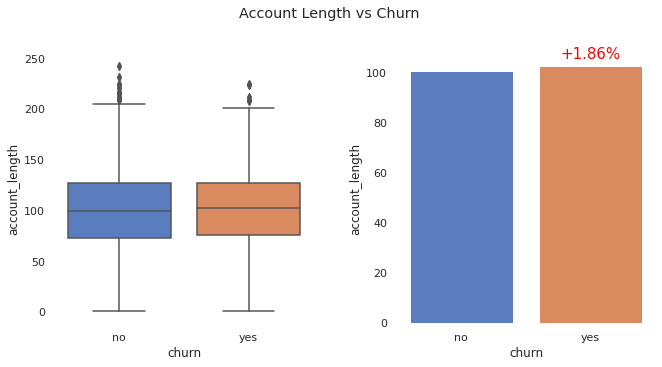

In [35]:
mean_not_churn = df[df["churn"] == "no"]["account_length"].mean()
mean_churn = df[df["churn"] == "yes"]["account_length"].mean()

dif = ((mean_churn - mean_not_churn) / mean_not_churn)*100

fig, ax = plt.subplots(1,2, figsize = (10,6))
sns.boxplot(data = df, x = "churn", y = "account_length", ax =ax[0])
sns.barplot(data = df, x = "churn", y = "account_length", ci = None, ax = ax[1])

ax[1].annotate(text = f"+{dif:.2f}%", xy = (1, mean_churn), xycoords = "data", size = 15, xytext=(-30, +7), textcoords='offset points', color = "red") 

plt.suptitle("Account Length vs Churn ", x = 0.5, y = 0.9)

fig.tight_layout(pad=3);

In [31]:
t_test("account_length")

Variancia das amostras são iguais. Aplicando o T-test 
stat = 1.499 p_value = 0.134
Não há evidências suficientes para rejeitar H0. Média das amostras são iguais


- O Número de meses que o consumidor esteve com o provedor atual também não se mostrou um bom indicativo de churn. Poderiamos pensar que clientes com uma longevidade maior teriam também uma fidelidade maior e portanto a evasão seria mais baixa. Entretanto, isso não foi observado.

### Mensagem por Voz vs Churn

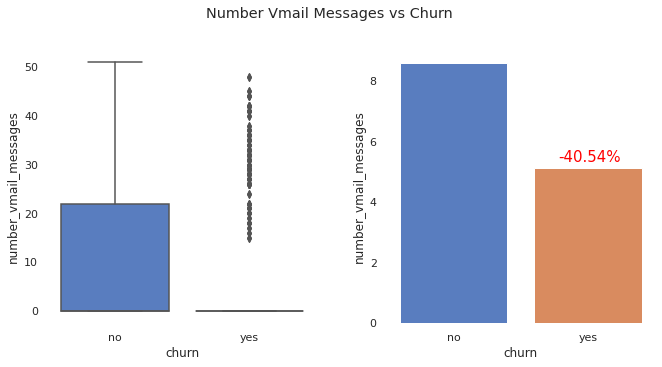

In [38]:
mean_not_churn = df[df["churn"] == "no"]["number_vmail_messages"].mean()
mean_churn = df[df["churn"] == "yes"]["number_vmail_messages"].mean()

dif = ((mean_churn - mean_not_churn) / mean_not_churn)*100

fig, ax = plt.subplots(1,2, figsize = (10,6))
sns.boxplot(data = df, x = "churn", y = "number_vmail_messages", ax =ax[0])
sns.barplot(data = df, x = "churn", y = "number_vmail_messages", ci = None, ax = ax[1])

ax[1].annotate(text = f"{dif:.2f}%", xy = (1, mean_churn), xycoords = "data", size = 15, xytext=(-30, +7), textcoords='offset points', color = "red") 

plt.suptitle("Number Vmail Messages vs Churn ", x = 0.5, y = 0.9)

fig.tight_layout(pad=3);

In [32]:
t_test("number_vmail_messages")

Amostras com diferentes variância, aplicando o Welch’s t-test 
stat = -8.002 p_value = 0.000
Rejeitamos a H0. A média da amostras são diferentes


- Aqui temos um padrão interessante: no geral, clientes que efetuam mais mensagens por voz são menos propensos ao churn, embora existam alguns outliers correspondentes a clientes que enviam muitas mensagens e mesmo assim abanonam a empresa.

### Correlação

Para análise da correlação entre variáveis numéricas, irei utilizar o coeficiente de correlação de Pearson que mede o grau de relação linear entre duas variáveis e varia de -1 (forte correlação negativa) a 1 (forte correlação positiva). Já para a relação entre features categoricas e churn, optei pela Mutual information, que mede o grau de dependência de duas features baseado em estimativas de entropia.

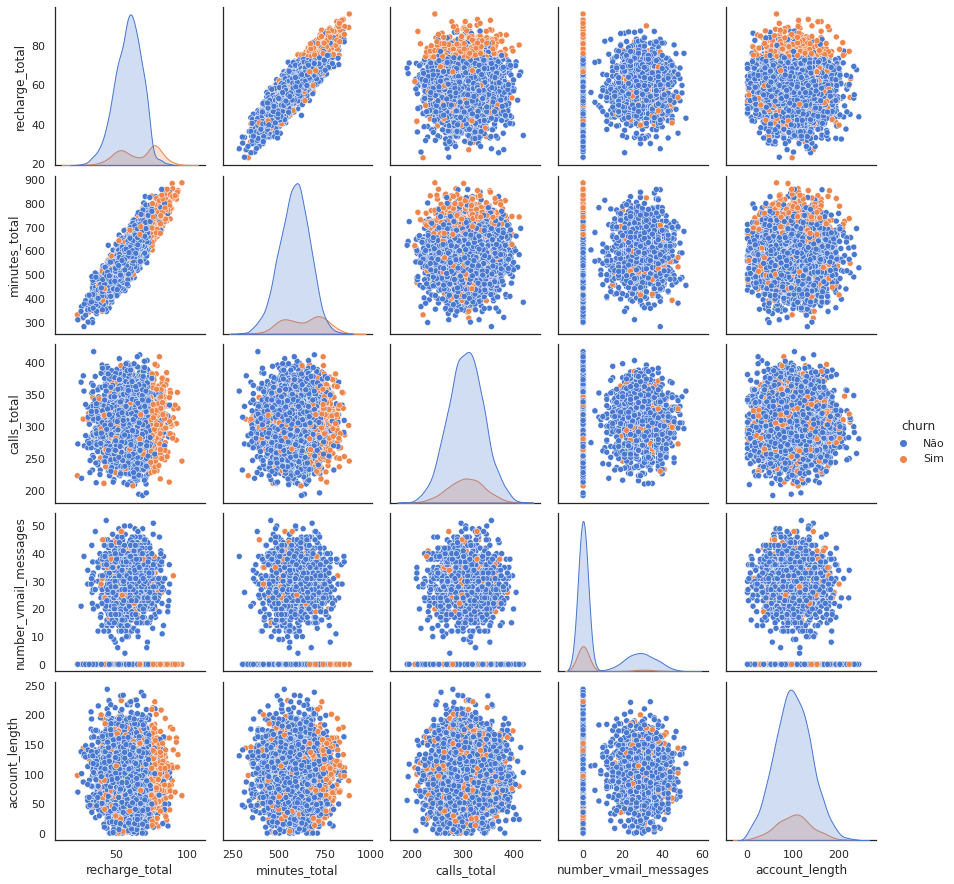

In [69]:
sns.pairplot(data=df[["recharge_total","minutes_total","calls_total","churn","number_vmail_messages","account_length"]], hue="churn");

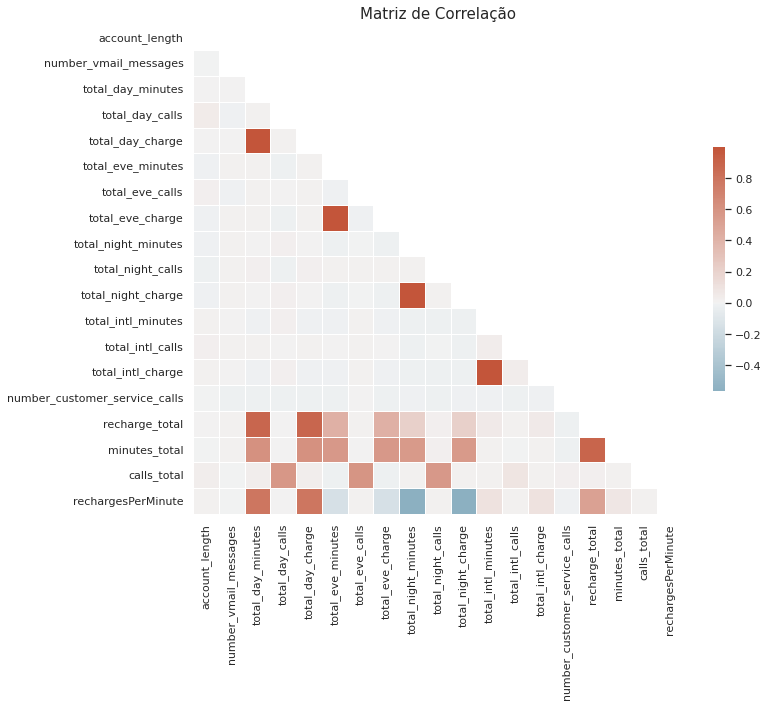

In [68]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap = cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("Matriz de Correlação", size = 15);

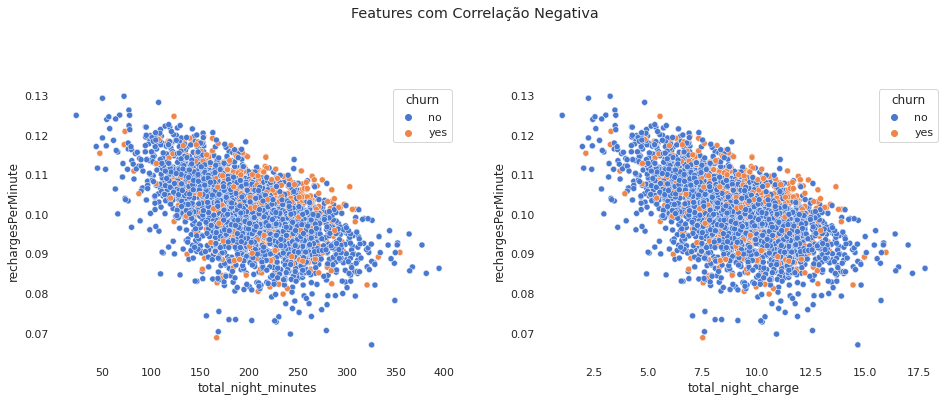

In [65]:
fig, ax = plt.subplots(1,2, figsize = (14,6))

sns.scatterplot(data = df, x = "total_night_minutes", y = "rechargesPerMinute", ax = ax[0], hue = "churn")
sns.scatterplot(data = df, x = "total_night_charge", y = "rechargesPerMinute", ax = ax[1], hue = "churn")
plt.suptitle("Features com Correlação Negativa")
fig.tight_layout(pad = 3);


''

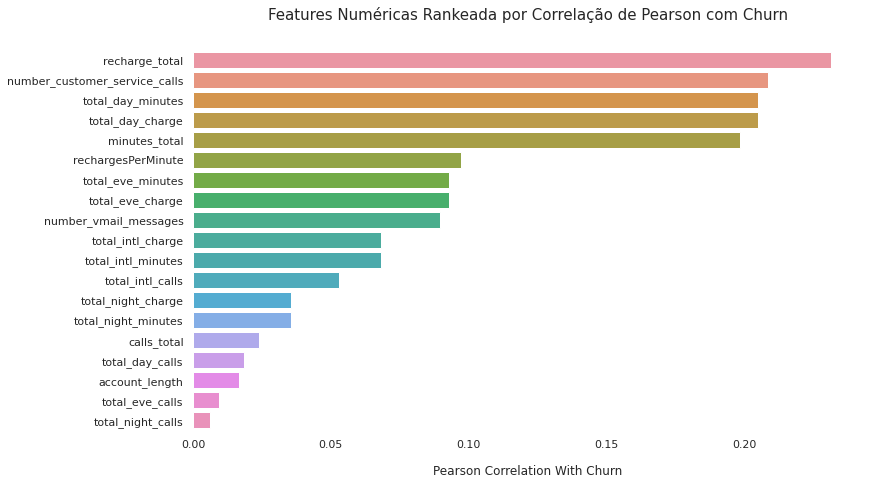

In [122]:
df_corr = df.copy()

df_corr["churn"] = df_corr["churn"].map({"no":0, "yes":1})

df_corr = abs(df_corr.corr()["churn"]).sort_values(ascending = False)[1:].reset_index()

fig, ax = plt.subplots(figsize = (12,7))
sns.barplot(data= df_corr, y = "index", x = "churn", orient = "h")
ax.set_xlabel("Pearson Correlation With Churn", labelpad=15)
ax.set_ylabel("")
ax.set_title("Features Numéricas Rankeada por Correlação de Pearson com Churn", size = 15, pad=30)
;

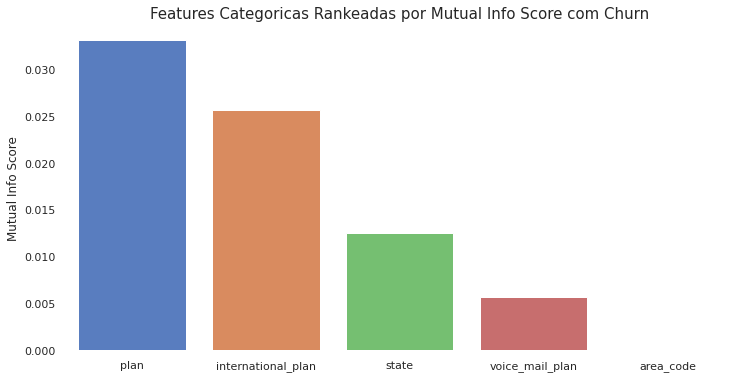

In [125]:
def compute_mutual_information(categorical_serie):
    return mutual_info_score(categorical_serie, df.churn)

categorical_variables = df.select_dtypes(include=object).drop('churn', axis=1)
feature_importance = categorical_variables.apply(compute_mutual_information).sort_values(ascending=False)

fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(y = feature_importance, x = feature_importance.index)
ax.set_ylabel("Mutual Info Score")
ax.set_title("Features Categoricas Rankeadas por Mutual Info Score com Churn", size = 15);

- Cobrança e Minutos possuem uma forte correlação positiva. Ou seja, clientes que passam muitos minutos em chamadas geram um retorno maior em cobranças. Novamente é possível observar que clientes rotativos dominam os valores mais altos na relação.  
- Curiosamente não há relação entre minutos e número de chamadas. Ou seja, clientes que realizam muitas chamadas não necessariamente passam muitos minutos ao telefone
- Minutos e Cobranças noturnas apresentaaram uma correlação negativa com Recarga por Minutos. Logo, clientes com elevado uso durante o período da noite são menos rentáveis.
- Como esperado, conforme as análises anteriores, número de chamadas e meses que o consumidor se manteve na empresa apresentaram uma baixa correlação com churn
- Area_code é praticamente independente do churn e por isso é pouco informativa para criação do modelo

### Cobranças (Período do Dia) vs Churn

In [69]:
charge = [i for i in df.columns if "charge" in i]
charge.remove("rechargesPerMinute")
charge.remove("recharge_total")

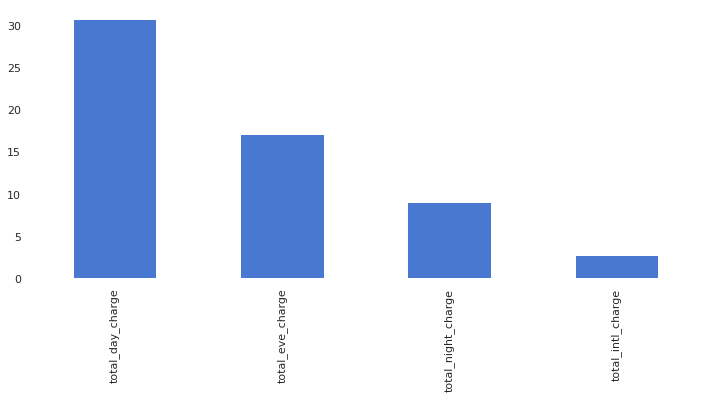

In [ ]:
df[charge].mean().plot.bar(figsize=(12,5));

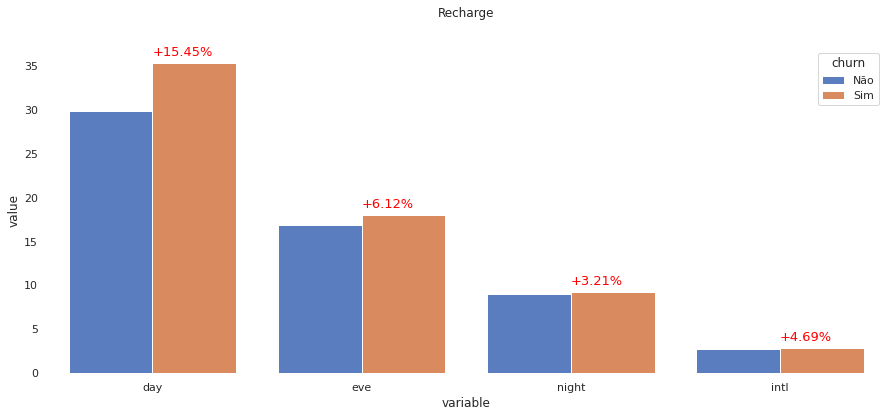

In [71]:
plot_charge = df.groupby("churn")[charge].mean().reset_index().melt("churn")
plot_charge.variable = plot_charge.variable.str.split("_", expand=True).iloc[:,1]
plot_charge.variable = plot_charge.variable.apply(lambda x: x.strip())

day_dif = ((plot_charge.iloc[1,2] - plot_charge.iloc[0,2]) / plot_charge.iloc[1,2])*100
eve_dif = ((plot_charge.iloc[3,2] - plot_charge.iloc[2,2]) / plot_charge.iloc[3,2])*100
night_dif = ((plot_charge.iloc[5,2] - plot_charge.iloc[4,2]) / plot_charge.iloc[5,2])*100
intl_dif = ((plot_charge.iloc[7,2] - plot_charge.iloc[6,2]) / plot_charge.iloc[7,2])*100


fig, ax = plt.subplots(figsize = (15,6))

sns.barplot(data = plot_charge,x  = "variable", y = "value", hue = "churn")

ax.annotate(text = f"+{day_dif:.2f}%", xy = (0, plot_charge.iloc[1,2]), xycoords = "data",
              size = 13, xytext=(0, 7), textcoords='offset points', color = "red")

ax.annotate(text = f"+{eve_dif:.2f}%", xy = (1, plot_charge.iloc[3,2]), xycoords = "data",
              size = 13, xytext=(0, 7), textcoords='offset points', color = "red")

ax.annotate(text = f"+{night_dif:.2f}%", xy = (2, plot_charge.iloc[5,2]), xycoords = "data",
              size = 13, xytext=(0, 7), textcoords='offset points', color = "red")

ax.annotate(text = f"+{intl_dif:.2f}%", xy = (3, plot_charge.iloc[7,2]), xycoords = "data",
              size = 13, xytext=(0, 7), textcoords='offset points', color = "red")
ax.set_title("Recharge", pad=30);

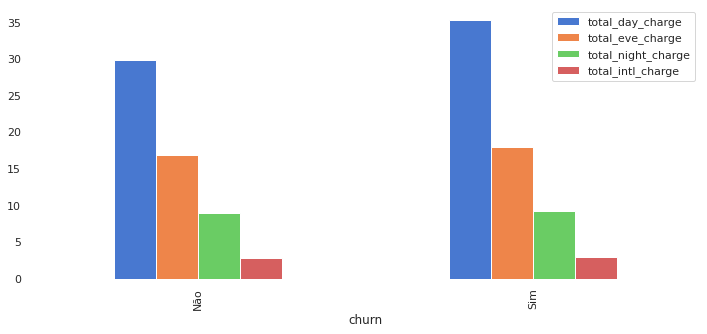

In [47]:
df.groupby("churn")[charge].mean().plot.bar(figsize=(12,5));

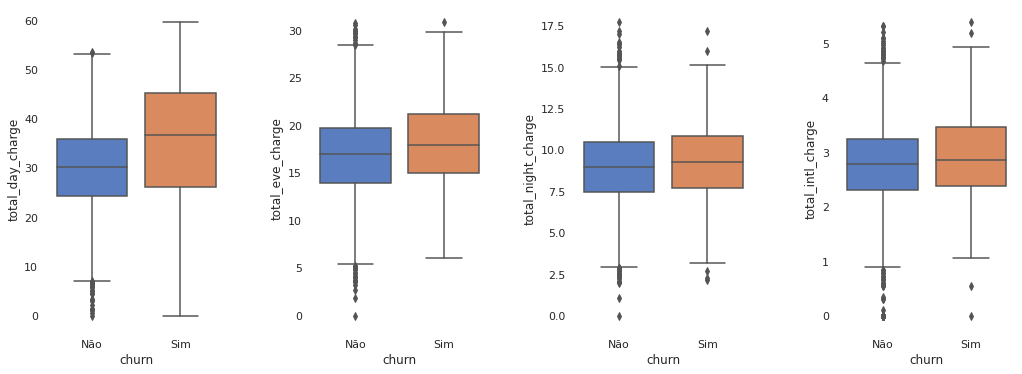

In [62]:
fig, ax = plt.subplots(1,4, figsize = (15,6))
for index, var in enumerate(charge):
    sns.boxplot(data = df, x = "churn", y = var, ax = ax.flat[index])
fig.tight_layout(pad=3);

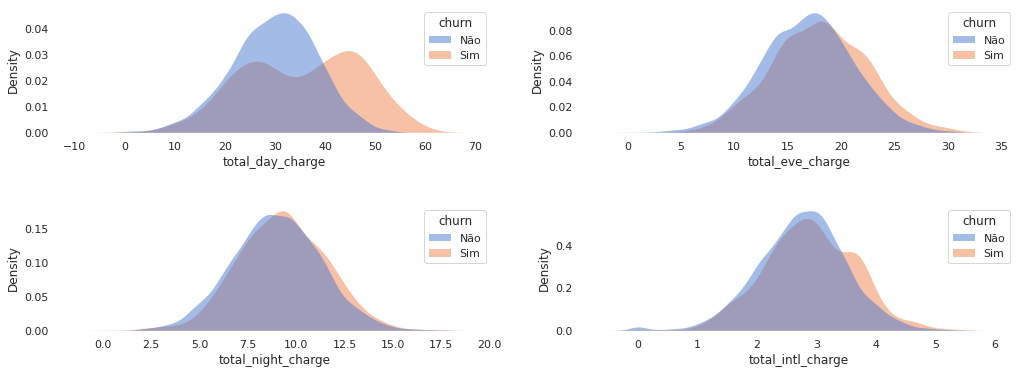

In [50]:
fig, ax = plt.subplots(2,2, figsize = (15,6))

for index, var in enumerate(charge):
    sns.kdeplot(x = df[var], hue = df["churn"], fill = True, common_norm=False, alpha=.5, linewidth=0, ax = ax.flat[index]);
fig.tight_layout(pad=3);


In [55]:
t_test("total_day_charge")

Amostras com diferentes variância, aplicando o Welch’s t-test 
stat = 11.950 p_value = 0.000
Rejeitamos a H0. A média da amostras são diferentes


In [56]:
t_test("total_eve_charge")

Variancia das amostras são iguais. Aplicando o T-test 
stat = 6.337 p_value = 0.000
Rejeitamos a H0. A média da amostras são diferentes


In [57]:
t_test("total_night_charge")

Variancia das amostras são iguais. Aplicando o T-test 
stat = 3.232 p_value = 0.001
Rejeitamos a H0. A média da amostras são diferentes


In [58]:
t_test("total_intl_charge")

Variancia das amostras são iguais. Aplicando o T-test 
stat = 4.482 p_value = 0.000
Rejeitamos a H0. A média da amostras são diferentes


### Minutos (Periodo do Dia) vs Churn

In [11]:
minutes = [i for i in df.columns if "minutes" in i]
minutes.remove("minutes_total")

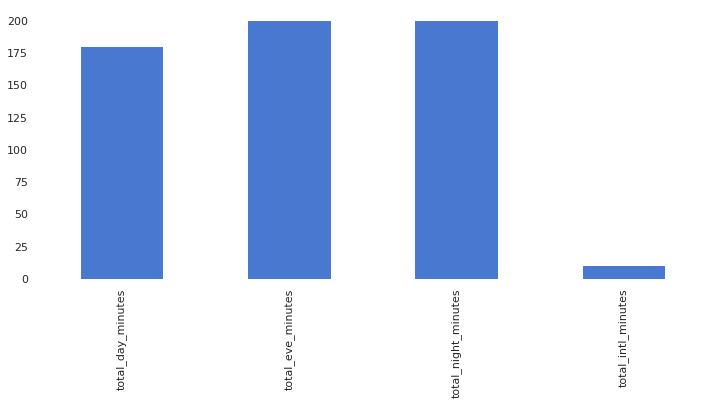

In [64]:
df[minutes].mean().plot.bar(figsize=(12,5));

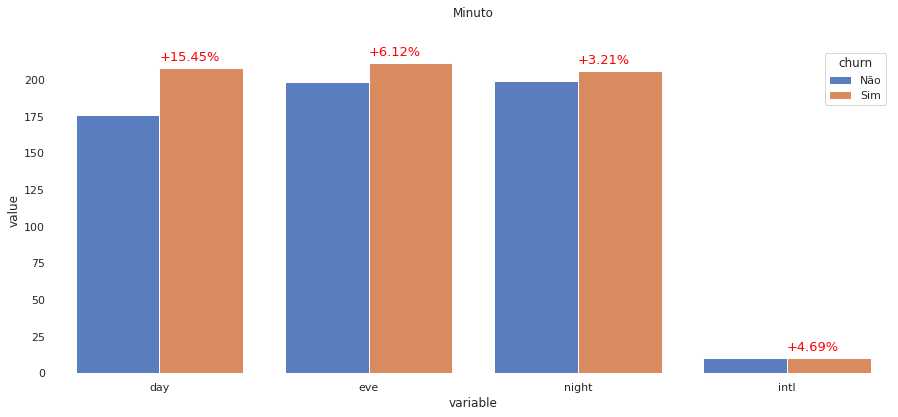

In [63]:
plot_minutes = df.groupby("churn")[minutes].mean().reset_index().melt("churn")
plot_minutes.variable = plot_minutes.variable.str.split("_", expand=True).iloc[:,1]
plot_minutes.variable = plot_minutes.variable.apply(lambda x: x.strip())

day_dif = ((plot_minutes.iloc[1,2] - plot_minutes.iloc[0,2]) / plot_minutes.iloc[1,2])*100
eve_dif = ((plot_minutes.iloc[3,2] - plot_minutes.iloc[2,2]) / plot_minutes.iloc[3,2])*100
night_dif = ((plot_minutes.iloc[5,2] - plot_minutes.iloc[4,2]) / plot_minutes.iloc[5,2])*100
intl_dif = ((plot_minutes.iloc[7,2] - plot_minutes.iloc[6,2]) / plot_minutes.iloc[7,2])*100

fig, ax = plt.subplots(figsize = (15,6))

sns.barplot(data = plot_minutes,x  = "variable", y = "value", hue = "churn")

ax.annotate(text = f"+{day_dif:.2f}%", xy = (0, plot_minutes.iloc[1,2]), xycoords = "data",
              size = 13, xytext=(0, 7), textcoords='offset points', color = "red")

ax.annotate(text = f"+{eve_dif:.2f}%", xy = (1, plot_minutes.iloc[3,2]), xycoords = "data",
              size = 13, xytext=(0, 7), textcoords='offset points', color = "red")

ax.annotate(text = f"+{night_dif:.2f}%", xy = (2, plot_minutes.iloc[5,2]), xycoords = "data",
              size = 13, xytext=(0, 7), textcoords='offset points', color = "red")

ax.annotate(text = f"+{intl_dif:.2f}%", xy = (3, plot_minutes.iloc[7,2]), xycoords = "data",
              size = 13, xytext=(0, 7), textcoords='offset points', color = "red")
ax.set_title("Minuto", pad=30);

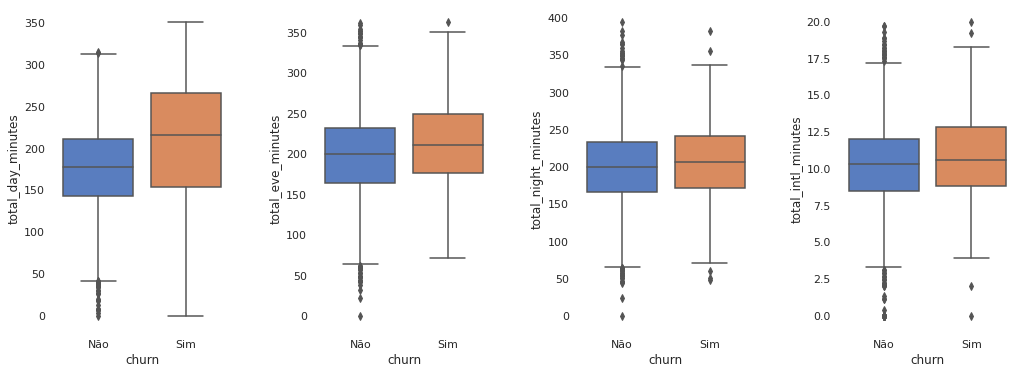

In [52]:
fig, ax = plt.subplots(1,4, figsize = (15,6))

for index, var in enumerate(minutes):
    sns.boxplot(data = df, x = "churn", y = var, ax = ax.flat[index])
fig.tight_layout(pad=3);

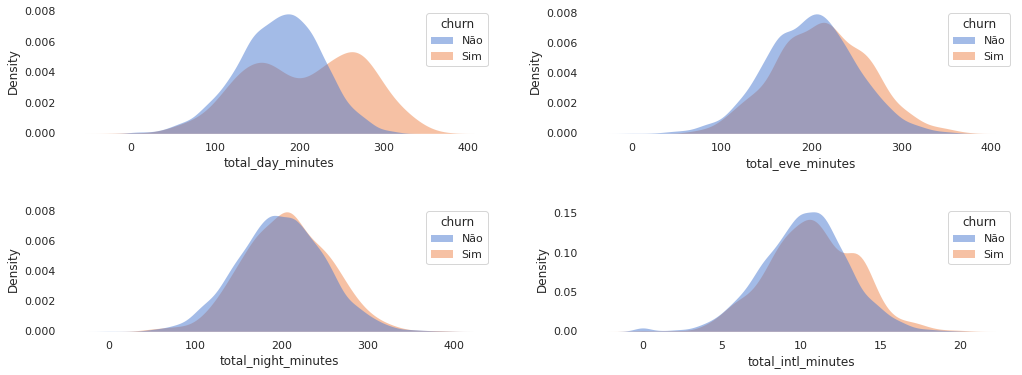

In [53]:
#minutes = [i for i in df.columns if "minutes" in i]
fig, ax = plt.subplots(2,2, figsize = (15,6))

for index, var in enumerate(minutes):
    sns.kdeplot(x = df[var], hue = df["churn"], fill = True, common_norm=False, alpha=.5, linewidth=0, ax = ax.flat[index]);
fig.tight_layout(pad=3);


In [34]:
t_test("total_day_minutes")

Amostras com diferentes variância, aplicando o Welch’s t-test 
stat = 11.951 p_value = 0.000
Rejeitamos a H0. A média da amostras são diferentes


In [35]:
t_test("total_eve_minutes")

Variancia das amostras são iguais. Aplicando o T-test 
stat = 6.338 p_value = 0.000
Rejeitamos a H0. A média da amostras são diferentes


In [36]:
t_test("total_night_minutes")

Variancia das amostras são iguais. Aplicando o T-test 
stat = 3.233 p_value = 0.001
Rejeitamos a H0. A média da amostras são diferentes


In [37]:
t_test("total_intl_minutes")

Variancia das amostras são iguais. Aplicando o T-test 
stat = 4.483 p_value = 0.000
Rejeitamos a H0. A média da amostras são diferentes


- No geral, os clientes passam mais minutos em chamadas no período da tarde e noite. Entretanto, o período de maior cobranças é pela manhã.

- Entre os grupos churn e não churn, o comportamento de gasto e minutos em chamadas foi diferente em todos os horários e também para chamadas internacionais.

- A arrecadação na forma de cobranças e os minutos em chamadas no período da manhã são 15% superior no grupo dos clientes que fazem churn em relação aos que não fazem. Ou seja, clientes que fazem o churn são mais ativos pela manhã do que os que permanecem.

### Chamadas (Período do Dia) vs Churn

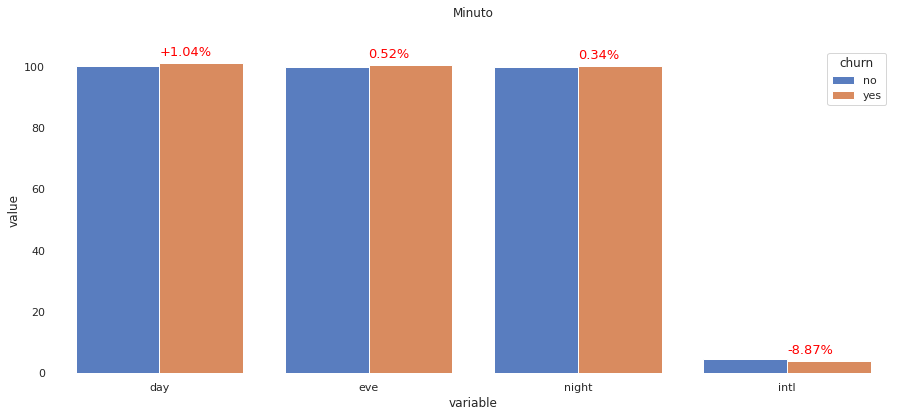

In [5]:
plot_calls = df.groupby("churn")[calls].mean().reset_index().melt("churn")
plot_calls.variable = plot_calls.variable.str.split("_", expand=True).iloc[:,1]
plot_calls.variable = plot_calls.variable.apply(lambda x: x.strip())

day_dif = ((plot_calls.iloc[1,2] - plot_calls.iloc[0,2]) / plot_calls.iloc[1,2])*100
eve_dif = ((plot_calls.iloc[3,2] - plot_calls.iloc[2,2]) / plot_calls.iloc[3,2])*100
night_dif = ((plot_calls.iloc[5,2] - plot_calls.iloc[4,2]) / plot_calls.iloc[5,2])*100
intl_dif = ((plot_calls.iloc[7,2] - plot_calls.iloc[6,2]) / plot_calls.iloc[7,2])*100

fig, ax = plt.subplots(figsize = (15,6))

sns.barplot(data = plot_calls,x  = "variable", y = "value", hue = "churn")

ax.annotate(text = f"+{day_dif:.2f}%", xy = (0, plot_calls.iloc[1,2]), xycoords = "data",
              size = 13, xytext=(0, 7), textcoords='offset points', color = "red")

ax.annotate(text = f"{eve_dif:.2f}%", xy = (1, plot_calls.iloc[3,2]), xycoords = "data",
              size = 13, xytext=(0, 7), textcoords='offset points', color = "red")

ax.annotate(text = f"{night_dif:.2f}%", xy = (2, plot_calls.iloc[5,2]), xycoords = "data",
              size = 13, xytext=(0, 7), textcoords='offset points', color = "red")

ax.annotate(text = f"{intl_dif:.2f}%", xy = (3, plot_calls.iloc[7,2]), xycoords = "data",
              size = 13, xytext=(0, 7), textcoords='offset points', color = "red")
ax.set_title("Minuto", pad=30);

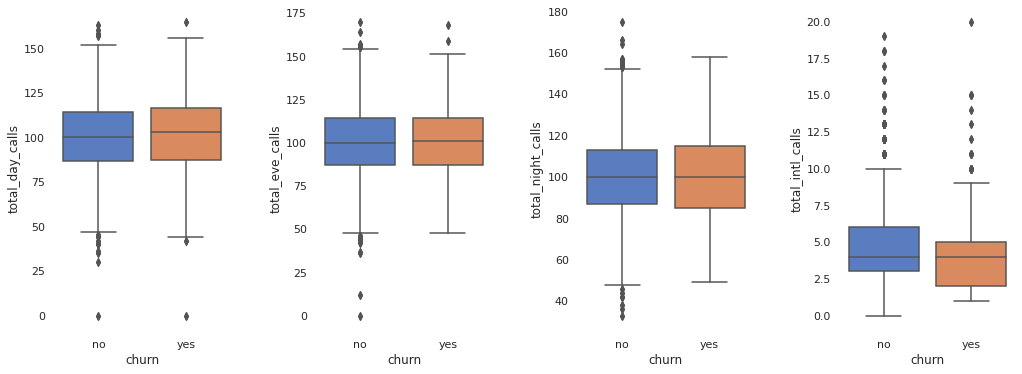

In [7]:
calls = [i for i in df.columns if "calls" in i]
calls.remove("number_customer_service_calls")
calls.remove("calls_total")
fig, ax = plt.subplots(1,4, figsize = (15,6))

for index, var in enumerate(calls):
    sns.boxplot(data = df, x = "churn", y = var, ax = ax.flat[index])
fig.tight_layout(pad=3);

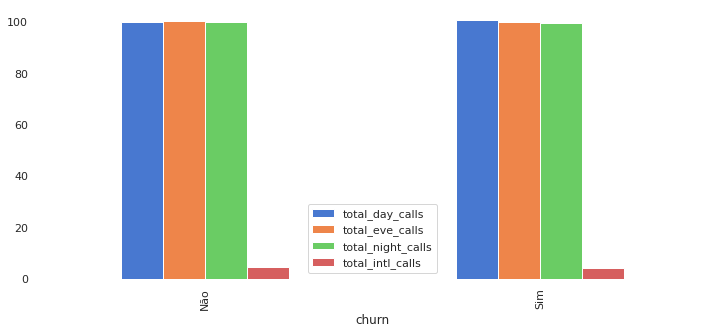

In [ ]:
df.groupby("churn")[["total_day_calls","total_eve_calls","total_night_calls","total_intl_calls"]].mean().plot.bar(figsize=(12,5));

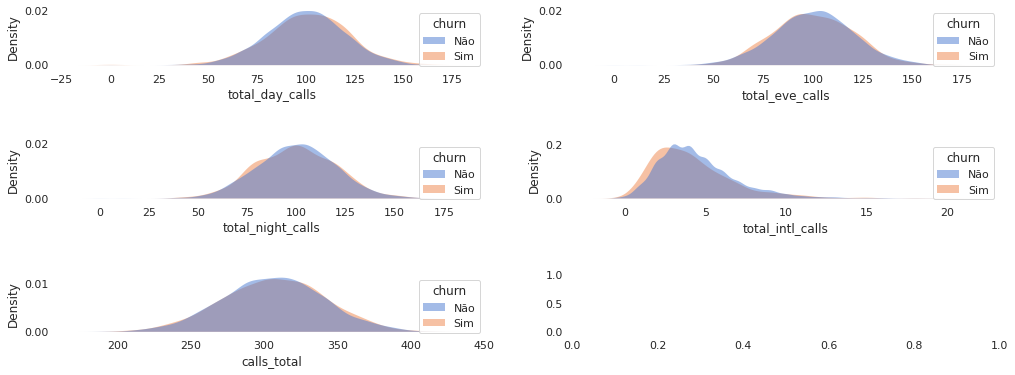

In [120]:
fig, ax = plt.subplots(3,2, figsize = (15,6))
for index, var in enumerate(calls):
    sns.kdeplot(x = df[var], hue = df["churn"], fill = True, common_norm=False, alpha=.5, linewidth=0, ax = ax.flat[index]);
fig.tight_layout(pad=3);

In [38]:
t_test("total_day_calls")

Variancia das amostras são iguais. Aplicando o T-test 
stat = 1.140 p_value = 0.254
Não há evidências suficientes para rejeitar H0. Média das amostras são iguais


In [39]:
t_test("total_eve_calls")

Variancia das amostras são iguais. Aplicando o T-test 
stat = -0.444 p_value = 0.657
Não há evidências suficientes para rejeitar H0. Média das amostras são iguais


In [40]:
t_test("total_night_calls")

Variancia das amostras são iguais. Aplicando o T-test 
stat = -0.494 p_value = 0.621
Não há evidências suficientes para rejeitar H0. Média das amostras são iguais


In [41]:
t_test("total_intl_calls")

Variancia das amostras são iguais. Aplicando o T-test 
stat = -3.319 p_value = 0.001
Rejeitamos a H0. A média da amostras são diferentes


- Para número de chamadas não houve diferença significativa entre diferentes horários e nem dentro dos grupos churn vs não churn.
- Clientes que não fazem o churn realizam 8% chamadas internacionais a mais do que os que saem da empresa. 

### Plano Adquirido vs Churn

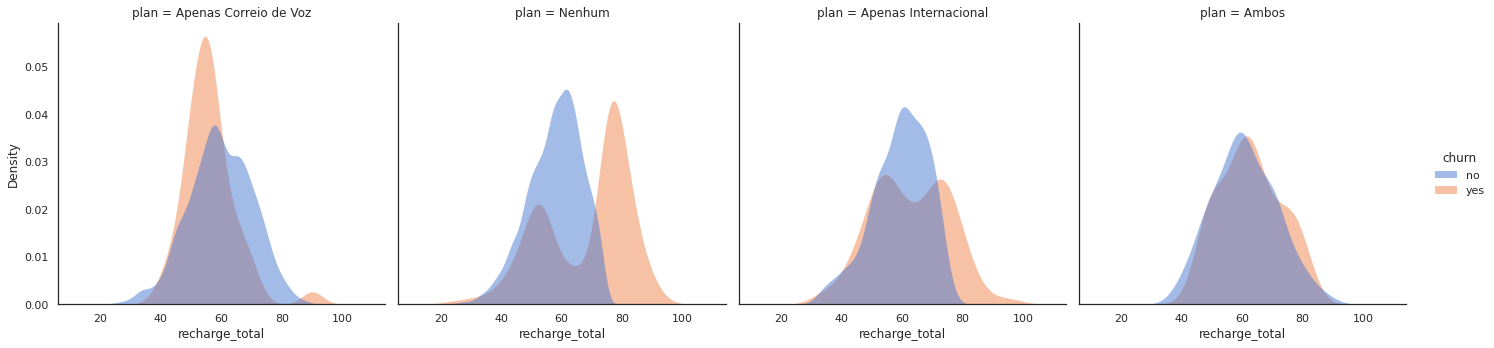

In [6]:
sns.displot(x = df["recharge_total"], hue = df["churn"], kind = "kde", fill = True, common_norm=False, alpha=.5, linewidth=0, col = df["plan"]);

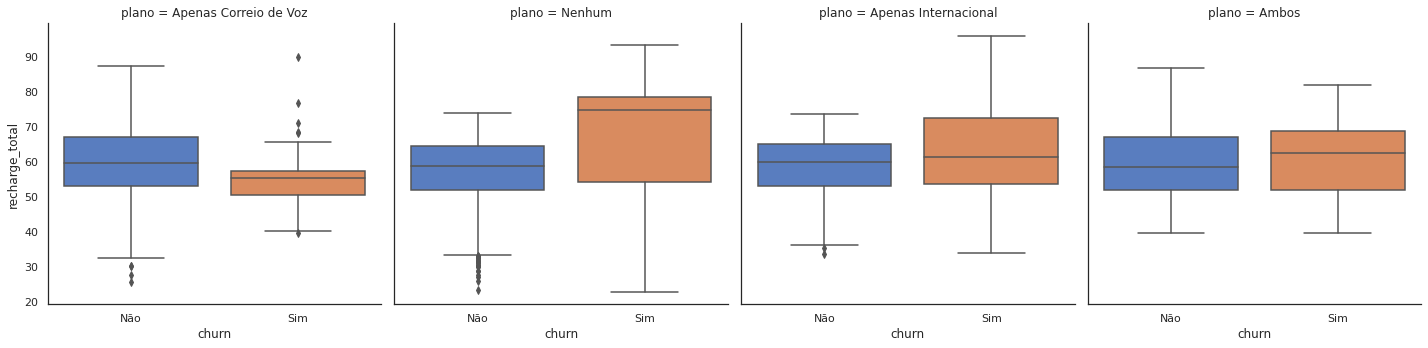

In [76]:
sns.catplot(data =df, x = "churn", y = "recharge_total", kind = "box", col = "plano");

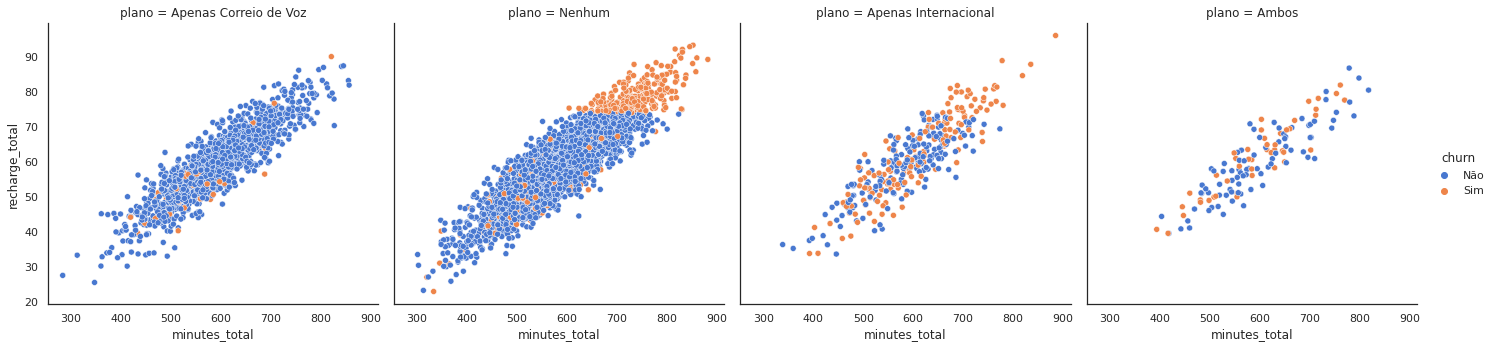

In [153]:
sns.relplot(data = df, y = "recharge_total", x = "minutes_total", hue = "churn", col = "plano");

In [154]:
df_plan = pd.DataFrame(df.groupby(["churn"])["plano"].value_counts(normalize = True)).rename(columns = {"plano":"perc"}).reset_index()
df_plan.head()

,churn,plano,perc
0,Não,Nenhum,0.671558
1,Não,Apenas Correio de Voz,0.264617
2,Não,Apenas Internacional,0.044025
3,Não,Ambos,0.019800
4,Sim,Nenhum,0.639321


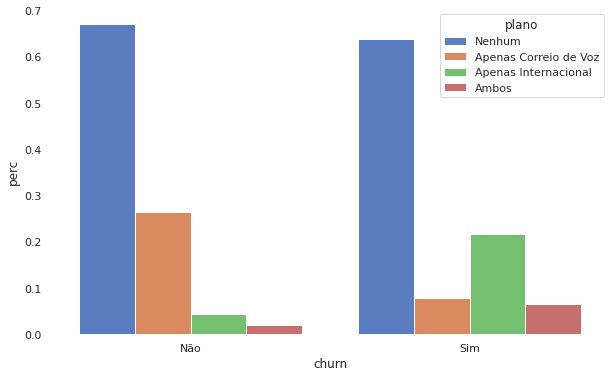

In [183]:
fig,ax = plt.subplots(figsize = (10,6))
sns.barplot(data = df_plan, x = "churn", y = "perc", ci = None, hue = "plano");

- Cerca de 25% dos clientes que fazem churn tem apenas o plano internacional, enquanto que menos de 5% dos clientes que permanecem na empresa tem apenas esse mesmo plano. Logo, ter apenas o plano internacional está relacionado com churn, embora não podemos afirmar que essa é a causa dos clientes abandonarem a empresa.
- De forma análoga, mais de 20% dos clientes que permanecem na empresa possuem apenas o plano de correio de voz, enquanto essa percentagem para os clientes que fizeram o churn é de menos de 10%. Logo, ter apenas esse plano parece estar associado com uma maior permanencia na empresa.
-  Apenas Correio de voz é o único plano no qual os clientes que permanecem na empresa são mais lucrativos que os que fazem churn. Dentre os clientes que não tem nenhum plano e apenas o internacional, os que fazem o churn são mais lucrativos. Para os que tem ambos os planos praticamente não há diferença na lucratividade.

## Estados vs Churn

In [83]:
df_state = df.groupby(["state","churn"]).count().iloc[:,1].reset_index()
df_state = df_state[df_state["churn"] == "yes"]
df_state["n_clients"] = df.groupby("state").count().iloc[:,1].values
df_state["prop"] = df_state.area_code / df_state.n_clients
df_state["renda"] = df.groupby("state").mean()["recharge_total"].values
df_state.rename(columns = {"area_code":"clients_churn"}, inplace=True)

In [84]:
df_state.head()

,state,churn,clients_churn,n_clients,prop,renda
1,AK,yes,6,104,0.058,57.350
3,AL,yes,16,160,0.100,59.443
5,AR,yes,22,110,0.200,59.076
7,AZ,yes,8,128,0.062,56.733
9,CA,yes,18,68,0.265,59.718


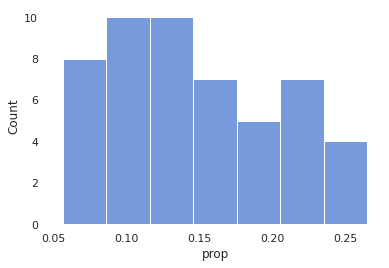

In [78]:
sns.histplot(data = df_state, x ="prop");

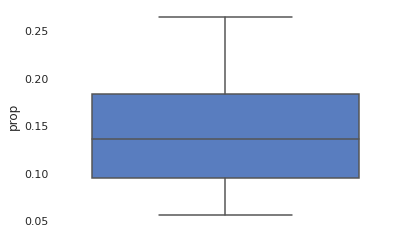

In [79]:
sns.boxplot(data = df_state, y ="prop");

In [85]:
df_state.describe()

,clients_churn,n_clients,prop,renda
count,51.000,51.000,51.000,51.000
mean,18.941,130.706,0.145,59.434
std,8.004,23.603,0.058,1.302
min,6.000,68.000,0.057,56.733
25%,13.000,119.000,0.096,58.703
50%,18.000,130.000,0.136,59.335
75%,25.000,145.000,0.183,60.104
max,36.000,212.000,0.265,62.788


In [133]:
high_churn = df_state.sort_values(by = "prop", ascending=False)[:10]
low_churn = df_state.sort_values(by = "prop", ascending=True)[:10]
high_clients = df_state.sort_values(by = "n_clients", ascending=False)[:10]
low_clients = df_state.sort_values(by = "n_clients", ascending=True)[:10]
high_renda = df_state.sort_values(by = "renda", ascending=False)[:10]
low_renda = df_state.sort_values(by = "renda", ascending=True)[:10]


high = pd.concat([high_churn, high_clients, high_renda], axis = 0)
low = pd.concat([low_churn, low_clients, low_renda], axis = 0)

high_states = set(high.state.values)
low_states = set(low.state.values)

all_states = set(df.state.values)

#estados que estão em alguma categoria dos maiores e dos menores simultaneamente
for state in all_states:
    if state in high_states and state in low_states:
        print(state)

WI
CA
WV
SC
VA


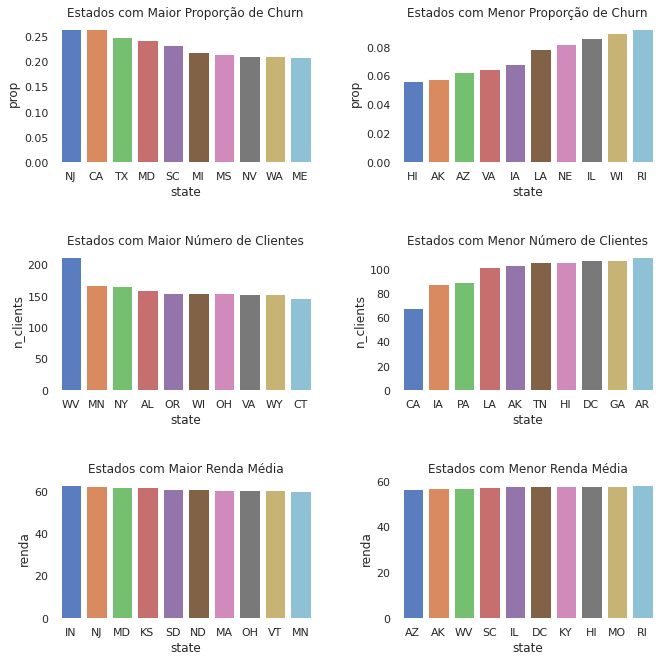

In [119]:
fig, ax = plt.subplots(3,2, figsize = (10,10))

ax.flat[0].set_title("Estados com Maior Proporção de Churn")
ax.flat[1].set_title("Estados com Menor Proporção de Churn")
ax.flat[2].set_title("Estados com Maior Número de Clientes")
ax.flat[3].set_title("Estados com Menor Número de Clientes")
ax.flat[4].set_title("Estados com Maior Renda Média")
ax.flat[5].set_title("Estados com Menor Renda Média")

sns.barplot(data=high_churn, x = "state", y = "prop", ax = ax.flat[0])
sns.barplot(data=low_churn, x = "state", y = "prop", ax = ax.flat[1])
sns.barplot(data=high_clients, x = "state", y = "n_clients", ax = ax.flat[2])
sns.barplot(data=low_clients, x = "state", y = "n_clients", ax = ax.flat[3])
sns.barplot(data=high_renda, x = "state", y = "renda", ax = ax.flat[4])
sns.barplot(data=low_renda, x = "state", y = "renda", ax = ax.flat[5])

fig.tight_layout(pad=3);

- Taxa de churn varia de 5% a 26% com uma média de 14% (± 5%).
- O estado da Califórnia (CA) foi o que teve a segunda maior taxa de churn ~25% e o menor número de clientes ~70
- Wisconsin (WI) foi um dos estados com menor taxa de churn ~8% e com maior número de clientes ~150
- Virgínia Ocidental (WV)} foi o estado com maior número de clientes ~200 e terceira menor renda média.
- A Carolina do Sul (SC) teve uma das maiores taxa de churn ~22% e a quarta menor renda média.
- A Virgínia (VA) teve a quarta menor taxa de churn ~6% e um dos maiores número de clientes ~150

# Feature Importance com Decision Tree

In [135]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,recharge_total,minutes_total,calls_total,rechargesPerMinute,plan
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no,75.56,717.2,304,0.105,Apenas Correio de Voz
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no,59.24,625.2,333,0.095,Apenas Correio de Voz
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no,62.29,539.4,333,0.115,Nenhum
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no,66.80,564.8,257,0.118,Apenas Internacional
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no,52.09,512.0,362,0.102,Apenas Internacional


In [7]:
X = df.drop(["state", "area_code", "churn"], axis  = 1)
y = df["churn"]

In [51]:
df_enc = df.copy()

enc = {"no":0, "yes":1}

df_enc["international_plan"] = df["international_plan"].map(enc)
df_enc["voice_mail_plan"] = df["voice_mail_plan"].map(enc)
df_enc["churn"] = df["churn"].map(enc)
df_enc.drop(["state","area_code"], axis = 1, inplace=True)

ohe = OneHotEncoder(cols=["plan"], return_df=True)
df_enc = ohe.fit_transform(df_enc)
df_enc.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,recharge_total,minutes_total,calls_total,rechargesPerMinute,plan_1,plan_2,plan_3,plan_4
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,75.56,717.2,304,0.105,1,0,0,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,59.24,625.2,333,0.095,1,0,0,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,62.29,539.4,333,0.115,0,1,0,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,66.80,564.8,257,0.118,0,0,1,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,52.09,512.0,362,0.102,0,0,1,0


In [50]:
X = df_enc.drop("churn", axis = 1)
y = df_enc["churn"]

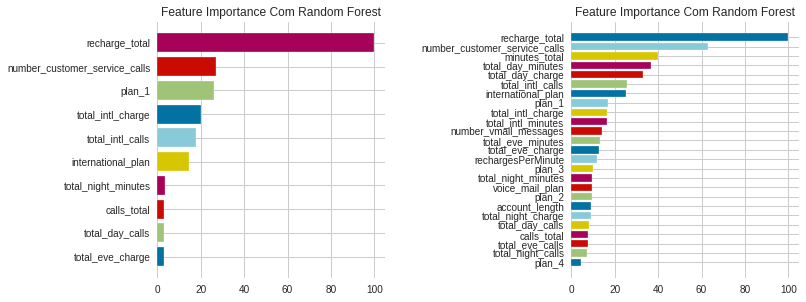

In [91]:
fig, ax = plt.subplots(1,2, figsize = (12,5))

model = DecisionTreeClassifier()
viz = FeatureImportances(model, topn=10, ax = ax[0])
viz.fit(X,y)
ax[0].set_title("Feature Importance Com Random Forest")

model2 = RandomForestClassifier()
viz2 = FeatureImportances(model2, top=10, ax = ax[1])
ax[1].set_title("Feature Importance Com Random Forest")
viz2.fit(X,y)
fig.tight_layout(pad=3);
